In [12]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm

In [3]:
# If working locally :
data_path = 'data/'

# First approach of the sentiment analysis 

## Polarity scores of quotes using Vader & TextBlob

In [66]:
sid = SentimentIntensityAnalyzer()

path_to_file = data_path+'Quotebank/quotes-2020.json.bz2' 
path_to_out = 'data/quotes-2020-polarity-scores.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance)
            quote = instance['quotation']
            scores = sid.polarity_scores(quote)
            instance['polarity_scores'] = scores
            #print(scores)
            d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compound': 0.872}
{'neg': 0.167, 'neu': 0.619, 'pos': 0.214, 'compound': 0.0}
{'neg': 0.113, 'neu': 0.84, 'pos': 0.046, 'compound': -0.4939}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'compound': 0.3041}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.038, 'neu': 0.888, 'pos': 0.074, 'compound': 0.3818}
{'neg': 0.121, 'neu': 0.715, 'pos': 0.165, 'compound': 0.2484}
{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'compound': 0.8277}


In [7]:
sid = SentimentIntensityAnalyzer()
text = "I am really extremely sad"
scores = sid.polarity_scores(text)
print(TextBlob(text).sentiment.polarity)
print(scores)

-0.5
{'neg': 0.479, 'neu': 0.521, 'pos': 0.0, 'compound': -0.5678}


In [20]:
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    dataframe = pd.DataFrame()
    c=0
    df = []
    first= True
    for i in s_file:
        if first:
            df = json.loads(i)
            df = pd.DataFrame.from_dict(df, orient="index")
            first=False
        else:
            dfa = json.loads(i)

            df2 = pd.DataFrame.from_dict(dfa, orient="index")
            df = pd.concat([df, df2], axis = 1)

            dataframe.append(json.loads(i),ignore_index=True)
        c+=1
        if c%100==0:
            print(c)
        if c >20000:
            break
df = df.transpose()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

## Extract only quotes from bz file (2012)

In [13]:
quotes = []
index =0
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    for ins in tqdm(s_file):
        quotes.append((re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)))

3053894it [01:48, 31484.69it/s]

KeyboardInterrupt: 

In [14]:
quotes = [i[0].decode() for i in quotes]

In [15]:
len(quotes)

3054567

3053894it [02:00, 31484.69it/s]

In [17]:
sentiments = []
neg = []
pos = []
neu = []
com = []
min_blob_vader_pos = []
max_blob_vader_pos= []
mean_scores = []
blobscores = []
for i in tqdm(quotes):
    scores = sid.polarity_scores(i)
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    com.append(scores['compound'])
    # adjust blobscore btw 0 and 1
    blobscore = TextBlob(i).sentiment.polarity
    blobscores.append(blobscore)
    if blobscore>0 and scores['pos']> 0:
        max_blob_vader_pos.append(max(scores['pos'],blobscore ))
        mean_scores.append(np.mean([scores['pos'],blobscore]))

    if blobscore<0 and scores['neg'] > 0:
        min_blob_vader_pos.append(max(scores['neg'],-blobscore ))
        mean_scores.append(np.mean([-scores['neg'],blobscore]))
    


  1%|          | 33135/3054567 [00:13<21:59, 2289.58it/s]


  2%|▏         | 67372/3054567 [00:27<19:52, 2504.01it/s]


  3%|▎         | 101365/3054567 [00:41<19:42, 2497.12it/s]


  4%|▍         | 134872/3054567 [00:54<19:31, 2492.83it/s]


  6%|▌         | 168451/3054567 [01:08<19:45, 2434.93it/s]


  7%|▋         | 201791/3054567 [01:21<19:01, 2499.48it/s]


  8%|▊         | 235128/3054567 [01:35<19:07, 2457.33it/s]


  9%|▉         | 268708/3054567 [01:48<18:44, 2477.66it/s]


 10%|▉         | 302161/3054567 [02:02<18:33, 2472.92it/s]


 11%|█         | 335387/3054567 [02:16<17:38, 2568.74it/s]


 12%|█▏        | 368336/3054567 [02:29<18:36, 2406.10it/s]


 13%|█▎        | 401599/3054567 [02:43<18:26, 2396.77it/s]


 14%|█▍        | 434908/3054567 [02:56<17:51, 2444.85it/s]


 15%|█▌        | 468370/3054567 [03:10<18:09, 2374.19it/s]


 16%|█▋        | 501416/3054567 [03:23<18:22, 2316.34it/s]


 17%|█▋        | 534327/3054567 [03:37<16:42, 2514.98it/s]


 19%|█▊        | 567539/3054567 [03:50<16:57, 2444.67it/s]


 20%|█▉        | 600695/3054567 [04:04<16:48, 2433.81it/s]


 21%|██        | 633646/3054567 [04:18<17:32, 2300.17it/s]


 22%|██▏       | 666922/3054567 [04:31<16:36, 2396.30it/s]


 23%|██▎       | 700444/3054567 [04:45<16:12, 2421.64it/s]


 24%|██▍       | 733797/3054567 [04:58<15:16, 2531.08it/s]


 25%|██▌       | 767066/3054567 [05:12<15:28, 2463.32it/s]


 25%|██▌       | 772093/3054567 [05:14<15:02, 2527.79it/s]

KeyboardInterrupt: 

In [18]:
import seaborn as sns

In [19]:
len(quotes2)

NameError: name 'quotes2' is not defined

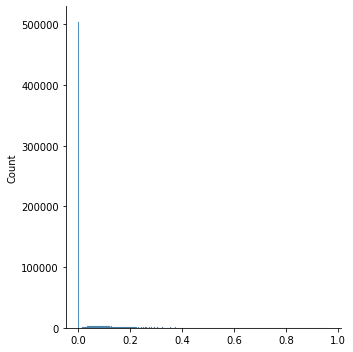

In [20]:

sns.displot(neg)

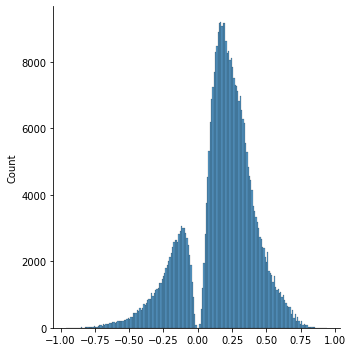

In [22]:

sns.displot(mean_scores, bins = 200)


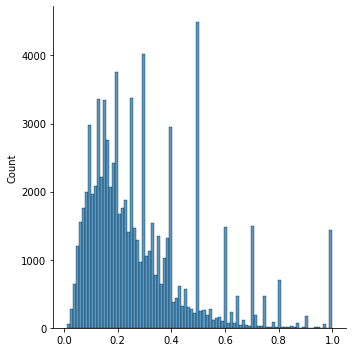

In [23]:
sns.displot(min_blob_vader_pos)

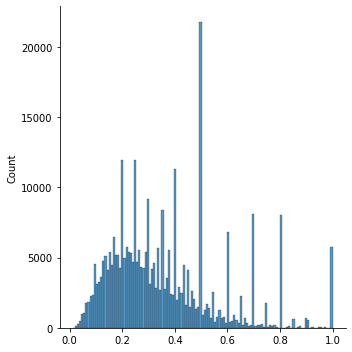

In [24]:
sns.displot(max_blob_vader_pos)

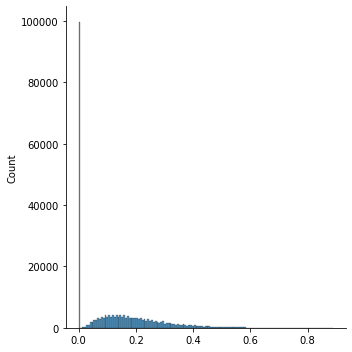

In [121]:
sns.displot(pos)

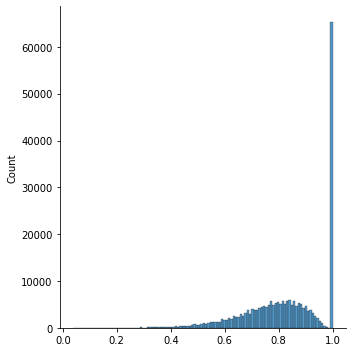

In [122]:
sns.displot(neu)

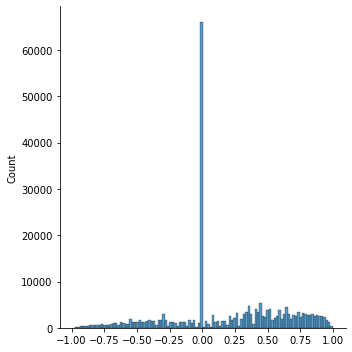

In [123]:
sns.displot(com)

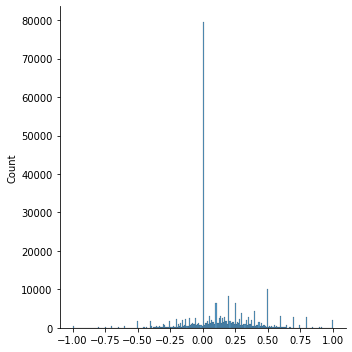

In [126]:
sns.displot(blobscore)

In [9]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
print(sentiment_analysis("I love this!"))

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
No module named 'tensorflow.python.keras.engine.keras_tensor'

In [1]:
import tensorflow as tf
from tensorflow import keras

In [11]:
! pip install keras==2.6.0

In [2]:
tf.__version__

'2.0.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [122]:
! conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/maxime/anaconda3

  added / updated specs:
    - cudatoolkit=10.2
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py37h06a4308_0         2.9 MB
    cudatoolkit-10.2.89        |       hfd86e86_1       365.1 MB
    ffmpeg-4.2.2               |       h20bf706_0        59.6 MB
    gnutls-3.6.15              |       he1e5248_0         1.0 MB
    lame-3.100                 |       h7b6447c_0         323 KB
    libidn2-2.3.2              |       h7f8727e_0          81 KB
    libopus-1.3.1              |       h7b6447c_0         491 KB
    libtasn1-4.16.0            |     

In [ ]:
pip install tensorflow
